<a href="https://colab.research.google.com/github/CrowdSalat/ann-dynamical-systems/blob/master/04_long_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# overview

Uses actions and an input state to predict the output state.

# imports

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import math
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *
from tensorflow.keras import metrics

2.0.0


In [0]:
base_folder = './results'
notebook_folder = '04_long_train'
results_folder = os.path.join(base_folder, notebook_folder)
os.makedirs(results_folder, exist_ok=True)
print('results_folder : ', results_folder)

saved_model_weight = 'saved_weights'
saved_model_weight_path = os.path.join(results_folder, saved_model_weight)
os.makedirs(saved_model_weight_path, exist_ok=True)


results_folder :  ./results/04_long_train


# mount drive

In [0]:
file = 'dataset_all_01.csv'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/xplane_data' 
os.chdir(root_dir)
print ('working dir: ' + os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
working dir: /content/drive/My Drive/xplane_data


# load data

## define features (actions & states)
actions and states at time t (t-1, t-2 ...) are the input for the network.

the states at time t + 1 are the desired output of the network.


In [0]:
col_m_time      = '   missn,_time '
col_t_time      = '   _totl,_time '
col_yaw_v       = '   ____Q,rad/s '

col_yaw_deg     = '   _beta,__deg '
col_roll_deg    = '   _roll,__deg '
col_roll_v      = '   ____R,rad/s '
col_pitch_deg   = '   pitch,__deg '
col_pitch_v     = '   ____P,rad/s '
col_alt         = '   __alt,ftmsl '
col_vv          = '   __VVI,__fpm '
col_v           = '   Vtrue,_ktas '
col_rpm_prop    = '   rpm_1,_prop '
col_throttle     = '   thro1,_part '

cols_state = [ 
    col_yaw_v,
    col_yaw_deg,
    col_roll_deg,
    col_roll_v,
    col_pitch_deg,
    col_pitch_v,
    col_vv,
    col_alt,
    col_v,

]

cols_time = [
    col_m_time,
    col_t_time,
]

col_elev_servo                  = '   _elev,servo '
col_ailrn_servo                  = '   ailrn,servo '
col_ruddr_servo                  = '   ruddr,servo '

cols_action = [
    col_elev_servo,
    col_ailrn_servo,
    col_ruddr_servo,
    col_rpm_prop,
    col_throttle,
]

# all input columns
cols_features = []
cols_features.extend(cols_state)
cols_features.extend(cols_action)

# orga column
col_dataset_index = 'dataset_index'
col_maneuver_index = 'maneuver_index'
col_maneuver_name = 'maneuver_name'
col_maneuver_datapoint_index = 'maneuver_datapoint_index'
col_maneuver_type = 'maneuver_type'
cols_org = [col_dataset_index, col_maneuver_index, col_maneuver_name,
            col_maneuver_datapoint_index,col_maneuver_type]



## load data

In [0]:
def load_xplane_csv(csv_path, columns):
    return pd.read_csv(csv_path, delimiter=',', usecols = columns, 
                       float_precision='high')

df_data = load_xplane_csv(file, cols_org + cols_state + cols_action)

print(len(cols_org))
print(len(cols_state))
print(len(cols_action))
print(df_data.shape)
df_data.head(2)

5
9
5
(477893, 19)


,dataset_index,maneuver_index,maneuver_name,maneuver_type,maneuver_datapoint_index,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl","thro1,_part","rpm_1,_prop","_elev,servo","ailrn,servo","ruddr,servo"
0,0,0,0,0,0,115.86147,665.39697,-0.03945,-0.00235,0.00008,-0.03584,-0.10129,0.00793,953.06787,0.79608,2443.89453,-0.00489,-0.01818,0.0
1,0,0,0,0,1,115.85403,650.10065,-0.03868,-0.00234,0.00007,-0.14285,-0.10772,0.00770,953.30768,0.79608,2443.77563,0.00134,-0.01815,0.0


# define data preperation functions

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, cols_label=None):
	data_in = data.drop(cols_org, axis=1)
	if cols_label == None:
		data_out = data_in.drop(cols_action, axis=1)
	else:
		if type(cols_label) != list:
			cols_label = [cols_label]
		data_out = data_in[cols_label]

	cols_in = data_in.columns
	cols_out = data_out.columns
	cols, names = list(), list()
	# input sequence (t-n, ... t-1, t)
	for i in range(n_in, 0, -1):
		cols.append(data_in.shift(i))
		if i == 1:
			names += [('%s(t)' % (col_in)) for col_in in cols_in]
		else:
			names += [('%s(t-%d)' % (col_in, i-1)) for col_in in cols_in]

	# forecast sequence (t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(data_out.shift(-i))
		names += [('%s(t+%d)' % (col_out, i+1)) for col_out in cols_out]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg, cols_out

In [0]:
def split_feature_label(data_labeled, n_input_steps):
  data_X = data_labeled.values[:, 0:n_input_steps*len(cols_features)]
  data_Y = data_labeled.values[:, n_input_steps*len(cols_features):]
  return data_X, data_Y

In [0]:
def scale_data(data_X, data_Y):
  feature_scaler = MinMaxScaler()
  data_X = feature_scaler.fit_transform(data_X)
  label_scaler = MinMaxScaler()
  data_Y = label_scaler.fit_transform(data_Y)
  return feature_scaler, label_scaler, data_X, data_Y

In [0]:
def prepare_datasets(data, n_in=1, n_out=1):
  #train-test-split
  test = data.query('dataset_index==4')
  train = data.query('dataset_index!=4')
  
  #add-label
  test_labeled, labels = series_to_supervised(test, n_in=n_in, n_out=n_out,dropnan=True)
  train_labeled, labels = series_to_supervised(train, n_in=n_in, n_out=n_out,dropnan=True)
  

  #split-feature-label
  train_X, train_Y = split_feature_label(train_labeled, n_in)
  test_X, test_Y = split_feature_label(test_labeled, n_in)
  #scale-feat
  feature_scaler, label_scaler, train_X, train_Y = scale_data(train_X, train_Y)
  #scale-label
  test_X, test_Y = feature_scaler.transform(test_X), label_scaler.transform(test_Y)

  return train_X, train_Y, test_X, test_Y, feature_scaler, label_scaler, labels


#TODO für RNN muss noch reshape stattfinden

# train models

## define callbacks functions

In [0]:
def prepare_tensorboard_callback(model_name=''):
  logs_base_dir = "./tensorbaord_logs"
  model_log_dir = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_' + model_name
  target_log_dir = os.path.join(logs_base_dir, model_log_dir)
  os.makedirs(target_log_dir, exist_ok=True)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(target_log_dir, histogram_freq=1)
  return tensorboard_callback


In [0]:
def prepare_checkpoint_callback(model_name):
  checkpoint_base_dir = './checkpoints'
  os.makedirs(checkpoint_base_dir, exist_ok=True)
  filepath = os.path.join(checkpoint_base_dir, 'cp_'+ model_name)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                  save_weights_only=True,
                                                  verbose=1)
  return cp_callback 

## define plot_and_save functions

### loss historie

In [0]:
def save_plots_before_show(diagramm_name):
  if not os.path.exists(results_folder):
      os.makedirs(diagramm_folder)

  plt.savefig(results_folder + '/' + diagramm_name +'.pdf')
  plt.savefig(results_folder + '/' + diagramm_name +'.svg')
  plt.savefig(results_folder + '/' + diagramm_name +'.png')

def pas_history(model_tupels, histories, key='mean_squared_error'):
  model_names = [model_tupel[0] for model_tupel in model_tupels]
  plt.figure(figsize=(16,10))
  for i, history in enumerate(histories):
    history_epoch= range(0, len(history['loss']) )

    val = plt.plot(history_epoch, history['val_'+key],
                   '--', label=model_names[i]+' Val')
    plt.plot(history_epoch, history[key], color=val[0].get_color(),
             label=model_names[i]+' Train')

  plt.xlabel('Epochs')
  plt.yscale("log")
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history_epoch)])
  save_plots_before_show('history_loss'+'_'+key)
  plt.show()

### metrics (overall and for all single targets )



In [0]:
def pas_metrics_scaled(model_tupel):
  model_name = model_tupel[0]
  df = _df_prediction_metrics(model_tupel, scaled=True)
  file_path = os.path.join(results_folder, model_name + '_scaled.csv')
  df.to_csv(path_or_buf=file_path)
  return df
  
def pas_metrics(model_tupel):
  model_name = model_tupel[0]
  df = _df_prediction_metrics(model_tupel, scaled=False)
  file_path = os.path.join(results_folder, model_name + '.csv')
  df.to_csv(path_or_buf=file_path)
  return df


def _df_prediction_metrics(model_tupel, scaled):
  '''
  creates describe dataframe of labels and 
  connect them with mse,rmse and mae per target and overall 
  '''
  
  model = model_tupel[1]
  train_X, train_Y, test_X, test_Y = model_tupel[2]
  cols_label = model_tupel[4]


  pred_Y = model.predict(test_X)
  
  if scaled:
    truth_Y = test_Y
  else:
    label_scaler = model_tupel[3]
    pred_Y = label_scaler.inverse_transform(pred_Y)
    truth_Y = label_scaler.inverse_transform(test_Y)

  df_describe = pd.DataFrame(truth_Y,columns=cols_label).describe()
  mses = mean_squared_error(truth_Y, pred_Y, multioutput='raw_values')
  rmses = np.array([math.sqrt(mse) for mse in mses])
  maes = mean_absolute_error(truth_Y, pred_Y, multioutput='raw_values')
  # average over list should do the job as well
  mse = mean_squared_error(truth_Y, pred_Y)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(truth_Y, pred_Y)


  df_mse_per_feature = pd.DataFrame(data=mses.reshape(1,-1),    # values
            index=['mses'],     # index
            columns=cols_label)  #  column names
  df_rmse_per_feature = pd.DataFrame(data=rmses.reshape(1,-1),    # values
        index=['rmes'],     # index
        columns=cols_label)  #  column names
  df_mae_per_feature = pd.DataFrame(data=maes.reshape(1,-1),    # values
        index=['maes'],     # index
        columns=cols_label)  #  column names
  
  
  df_mse_all = pd.DataFrame(data=mse,    # values
            index=['mse'],     # index
            columns=cols_label)  #  column names
  df_rmse_all = pd.DataFrame(data=rmse,    # values
        index=['rme'],     # index
        columns=cols_label)  #  column names
  df_mae_all = pd.DataFrame(data=mae,    # values
        index=['mae'],     # index
        columns=cols_label)  #  column names
  

  metrics = [df_mse_per_feature, df_rmse_per_feature, df_mae_per_feature, 
             df_mse_all,df_rmse_all,df_mae_all]
  return df_describe.append(metrics)

## define models

In [0]:
def create_model(model_name, layers, keras_activation, kernel_initializer, 
                 loss, metrics,  n_in=1, n_out=1):
  if not layers:
    raise Exception('No layers defined. Expected in format [100,100]') 

 #prepare data
  train_X, train_Y, test_X, test_Y, feature_scaler, label_scaler, labels = prepare_datasets(df_data, n_in, n_out)
  features_nr = train_X.shape[1]
  target_nr = train_Y.shape[1]
    
  model = keras.Sequential(name=model_name)
  
  model.add(Dense(layers[0],input_shape=(features_nr,), 
                          kernel_initializer=kernel_initializer))
  model.add(keras_activation())
  for i in range(1, len(layers)):
    layer_val = layers[i]
    model.add(Dense(layer_val, kernel_initializer=kernel_initializer))
    model.add(keras_activation())

  model.add(Dense(target_nr ))

  model.compile(optimizer='adam',
                        loss=loss,
                        metrics=metrics)

  model.summary()
  print(model.to_json())
  print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
  return (model_name, model, (train_X, train_Y, test_X, test_Y), label_scaler, labels)


In [0]:
loss='mean_squared_error',
metrics=['mean_squared_error', 'mean_absolute_error']


model_2x500 = create_model('model_2x500', [500, 500], ReLU, 'he_uniform', 
             loss, metrics)

model_2x400 = create_model('model_2x400', [400, 400], ReLU, 'he_uniform', 
             loss, metrics)

model_200 = create_model('model_200', [200], ReLU, 'he_uniform', 
             loss, metrics)

models = [
          model_2x500,
          model_2x400,
          model_200,
      
]

Model: "model_2x500"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               7500      
_________________________________________________________________
re_lu (ReLU)                 (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 4509      
Total params: 262,509
Trainable params: 262,509
Non-trainable params: 0
_________________________________________________________________
{"class_name": "Sequential", "config": {"name": "model_2x500", "layers": [{"class_name": "Dense", "config": {"name"

## train, save and load model

In [0]:
def train_model(model_tupel, epochs, batch_size):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  train_X, train_Y, test_X, test_Y = model_tupel[2]

  callbacks = [
              #prepare_checkpoint_callback(model_name=model_name),
              #prepare_tensorboard_callback(model_name=model_name)
              ]

  history = keras_model.fit(train_X,
                            train_Y,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(test_X, test_Y),
                            verbose=2,
                            callbacks=callbacks
                            )
  return history  

def _format_model_path(model_name):
  file_name = '{}_end'.format(model_name)
  return os.path.join(saved_model_weight_path, file_name)

def save_model(model_tupel):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  file_path = _format_model_path(model_name)
  keras_model.save_weights(file_path)

def load_model(model_tupel):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  file_path = _format_model_path(model_name)
  exact_file_path = file_path + '.index'
  if os.path.isfile(exact_file_path):
    print('load model {}'.format(model_name))
    keras_model.load_weights(file_path)
    return True
  else:
    return False

def _format_history_path(model_name):
  file_name = '{}_history_dict'.format(model_name)
  return os.path.join(results_folder, file_name)
  

def save_history(model_tupel, history):
  file_path = _format_history_path(model_tupel[0])
  with open(file_path, 'wb') as file_hist:
        pickle.dump(history.history, file_hist)
  

def load_history(model_tupel):
  file_path = _format_history_path(model_tupel[0])
  if not os.path.isfile(file_path):
    return dict()
  with open(file_path, 'rb') as file_hist:
    return pickle.load(file_hist)

In [0]:
histories = []
for model in models:
  if not load_model(model):
    print(model[0])
    history = train_model(model, epochs=100, batch_size=64)
    save_model(model)
    save_history(model, history)
    histories.append(history.history)
    print('*******************')
  else:
    history = load_history(model)
    histories.append(history)

model_2x500
Train on 330984 samples, validate on 146907 samples
Epoch 1/100
330984/330984 - 24s - loss: 9.0401e-04 - mean_squared_error: 9.0401e-04 - mean_absolute_error: 0.0113 - val_loss: 1.4306e-04 - val_mean_squared_error: 1.4306e-04 - val_mean_absolute_error: 0.0080
Epoch 2/100
330984/330984 - 23s - loss: 7.2693e-05 - mean_squared_error: 7.2693e-05 - mean_absolute_error: 0.0063 - val_loss: 6.8363e-05 - val_mean_squared_error: 6.8363e-05 - val_mean_absolute_error: 0.0058
Epoch 3/100
330984/330984 - 23s - loss: 2.7102e-05 - mean_squared_error: 2.7102e-05 - mean_absolute_error: 0.0038 - val_loss: 5.4511e-05 - val_mean_squared_error: 5.4511e-05 - val_mean_absolute_error: 0.0050
Epoch 4/100
330984/330984 - 23s - loss: 1.6168e-05 - mean_squared_error: 1.6168e-05 - mean_absolute_error: 0.0028 - val_loss: 3.4487e-05 - val_mean_squared_error: 3.4487e-05 - val_mean_absolute_error: 0.0036
Epoch 5/100
330984/330984 - 23s - loss: 1.1936e-05 - mean_squared_error: 1.1936e-05 - mean_absolute_erro

## visualize

### Test & Training Loss

In [0]:
for i, history in enumerate(histories):
  last_loss = history['loss'][-1]
  last_val_loss = history['val_loss'][-1]
  model_name = models[i][0]
  print('{} model last loss: {}'.format(model_name,last_loss))
  print('{} model last val loss: {}'.format(model_name,last_val_loss))
  print('*******')

model_2x500 model last loss: 2.911079356857602e-06
model_2x500 model last val loss: 2.6835626180211496e-05
*******
model_2x400 model last loss: 2.7812689524818215e-06
model_2x400 model last val loss: 2.5368785037736533e-05
*******
model_200 model last loss: 2.600873209489758e-06
model_200 model last val loss: 2.6506395840577124e-05
*******


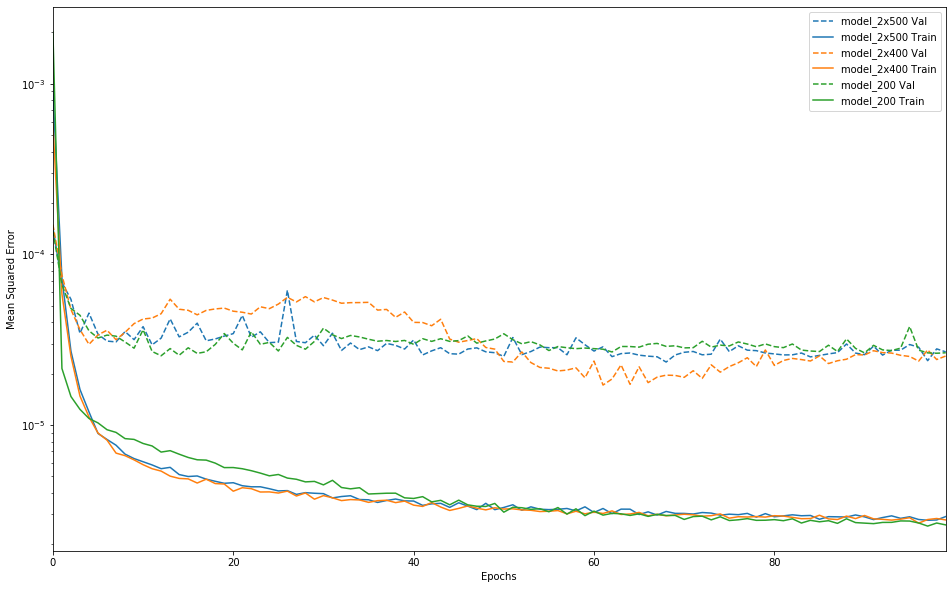

In [0]:
pas_history(models, histories=histories)


### MSE per target (scaled)

In [0]:
for model_tupel in models:
  df = pas_metrics_scaled(model_tupel)
  print(model_tupel[0])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                         'display.width', 1000): 
    print(df)
  print('*********************************************************')

model_2x500
          Vtrue,_ktas      __VVI,__fpm      ____Q,rad/s      ____P,rad/s      ____R,rad/s      pitch,__deg      _roll,__deg      _beta,__deg      __alt,ftmsl 
count    146907.000000    146907.000000    146907.000000    146907.000000    146907.000000    146907.000000    146907.000000    146907.000000    146907.000000
mean          0.504412         0.737227         0.570341         0.485060         0.485233         0.531587         0.464654         0.620080         0.541116
std           0.106511         0.106115         0.096593         0.137143         0.297851         0.109146         0.243538         0.211064         0.313282
min          -0.145712         0.315198         0.075314        -0.114067         0.001815         0.194934         0.019929        -0.224448         0.020174
25%           0.491325         0.719309         0.483381         0.478066         0.141444         0.498651         0.178618         0.402814         0.258517
50%           0.516065         0.7

### MSE per target (unscaled)

In [0]:
models[1][0]

'model_2x400'

In [0]:
for model_tupel in models:
  df = pas_metrics(model_tupel)
  print(model_tupel[0])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                        'display.width', 1000):  
    print(df)
  print('*********************************************************')

model_2x500
          Vtrue,_ktas      __VVI,__fpm      ____Q,rad/s      ____P,rad/s      ____R,rad/s      pitch,__deg      _roll,__deg      _beta,__deg      __alt,ftmsl 
count    146907.000000    146907.000000     1.469070e+05    146907.000000     1.469070e+05    146907.000000    146907.000000    146907.000000    146907.000000
mean        116.933735         1.454978     7.135510e-03        -0.000140    -1.337600e-03        -0.605152        -0.722674         0.024940      3118.794644
std           8.275017       276.265852     7.759326e-03         0.025104     3.282916e-02         1.788004        12.122463         0.178670      1339.530659
min          66.424780     -1097.281130    -3.263000e-02        -0.109810    -5.462000e-02        -6.120130       -22.859510        -0.689970       891.350710
25%         115.917000       -45.193610     1.500000e-04        -0.001420    -3.923000e-02        -1.144705       -14.960540        -0.158980      1910.458070
50%         117.839070         0.1

#latex

In [0]:
def _df_prediction_metrics_all(model_tupel, scaled):
  
  model_name =  model_tupel[0]
  model = model_tupel[1]
  train_X, train_Y, test_X, test_Y = model_tupel[2]
  cols_label = model_tupel[4]


  pred_Y = model.predict(test_X)
  
  if scaled:
    truth_Y = test_Y
  else:
    label_scaler = model_tupel[3]
    pred_Y = label_scaler.inverse_transform(pred_Y)
    truth_Y = label_scaler.inverse_transform(test_Y)

  df_describe = pd.DataFrame(truth_Y,columns=cols_label).describe()
  mses = mean_squared_error(truth_Y, pred_Y, multioutput='raw_values')
  #rmses = np.array([math.sqrt(mse) for mse in mses])
  #maes = mean_absolute_error(truth_Y, pred_Y, multioutput='raw_values')
  # average over list should do the job as well
  mse = mean_squared_error(truth_Y, pred_Y)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(truth_Y, pred_Y)


  df_mse_per_feature = pd.DataFrame(data=mses.reshape(1,-1),    # values
            index=[model_name],     # index
            columns=cols_label)  #  column names
  
  df_mse_per_feature['MSE'] = mse
  df_mse_per_feature['RMSE'] = rmse
  df_mse_per_feature['MAE'] = mae


  #df_rmse_per_feature = pd.DataFrame(data=rmses.reshape(1,-1),    # values
   #     index=['rmes'],     # index
  #      columns=cols_label)  #  column names
  #df_mae_per_feature = pd.DataFrame(data=maes.reshape(1,-1),    # values
    #    index=['maes'],     # index
   #     columns=cols_label)  #  column names
  
  return df_mse_per_feature


def pas_metrics_all(models):
  cols_trans = ['MSE', 'RMSE', 'MAE', col_vv,col_alt, col_v]
  cols_rot = [col_roll_deg, col_pitch_deg, col_yaw_deg, col_pitch_v, col_yaw_v, col_roll_v]
  rows_trans = []
  rows_rot = []

  for model_tupel in models:
    model_row = _df_prediction_metrics_all(model_tupel, scaled=False)
    rows_trans.append(model_row[cols_trans])
    rows_rot.append(model_row[cols_rot])

  df_trans = pd.concat(rows_trans).round(2)
  file_path = os.path.join(results_folder, 'all_mse_trans' + '.csv')
  df_trans.to_csv(path_or_buf=file_path)
  
  df_rot = pd.concat(rows_rot).round(10)
  file_path = os.path.join(results_folder, 'all_mse_rot' + '.csv')
  df_rot.to_csv(path_or_buf=file_path)
  return df_trans, df_rot


df_trans, df_rot = pas_metrics_all(models)
  

In [0]:
df_trans

,MSE,RMSE,MAE,"__VVI,__fpm","__alt,ftmsl","Vtrue,_ktas"
model_2x500,68.62,8.28,1.26,350.94,266.45,0.14
model_2x400,125.92,11.22,1.63,317.30,815.70,0.23
model_200,104.61,10.23,0.91,65.76,875.20,0.51


In [0]:
df_rot

,"_roll,__deg","pitch,__deg","_beta,__deg","____P,rad/s","____Q,rad/s","____R,rad/s"
model_2x500,0.026259,0.005353,0.000020,1.313300e-06,1.704000e-07,3.495000e-07
model_2x400,0.018534,0.003593,0.000020,4.571000e-07,1.368000e-07,1.790000e-07
model_200,0.011895,0.005288,0.000007,3.132000e-07,1.698000e-07,3.344000e-07


#predict one ahead

In [0]:
def make_prediction(model, test_X, seq_len, n_labels, seq_start=0):
  predictions = np.empty(n_labels).reshape(1,-1)  
  input_state = test_X[seq_start,:].reshape(1,-1)
  for i in range(seq_start , seq_start+ seq_len):
    pred_Y = model.predict(input_state)
    state_offset = pred_Y.shape[1]
    action_t1 = test_X[i+1, state_offset:]
    input_state = np.concatenate((pred_Y, action_t1.reshape(1,-1)), axis=None).reshape(1,-1)
    predictions = np.concatenate((predictions,pred_Y))
  return np.delete(predictions, (0), axis=0) #delete first empty row

def get_descaled_dataframe(test_Y, predictions, label_scaler):
  truth = test_Y[:len(predictions),:]
  truth = label_scaler.inverse_transform(truth)
  predictions = label_scaler.inverse_transform(predictions)
  df_pred = pd.DataFrame(data=predictions, columns=label) 
  df_real = pd.DataFrame(data=truth, columns=label) 
  return df_real, df_pred

def print_pred_and_actual(pred, actual):
  pred_columns = pred.columns
  actual_columns = actual.columns
  #pred_column_name = pred_columns[0]
  #actual_column_name = actual_columns[0]
  for pred_column_name, actual_column_name in zip(pred_columns,actual_columns):
    pred_column = pred[pred_column_name]
    actual_column = actual[actual_column_name]
    #for i in range(len(actual_column)):
    true = plt.plot(range(0, len(actual_column)), actual_column, label=pred_column_name+' true')
    plt.plot(range(0, len(actual_column)), pred_column,'--',color=true[0].get_color(), label=actual_column_name+' pred')
    plt.xlabel('Zeitschritte')
    plt.ylabel(pred_column_name)
    plt.legend()
    plt.show()

In [0]:
model_tupel = models[0]

model = model_tupel[1]
train_X, train_Y, test_X, test_Y = model_tupel[2]
label_scaler = model_tupel[3]
label = model_tupel[4]

print(model_tupel[0])

predictions = make_prediction(model, test_X, 100, len(cols_state), 0)

model_2x500


In [0]:
df_real, df_pred = get_descaled_dataframe(test_Y, predictions, label_scaler)

In [0]:
df_real

,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl"
0,121.08971,28.07388,-0.00073,0.00080,0.00040,-1.01648,-0.06779,0.01813,898.92804
1,121.08601,28.55564,-0.00074,0.00076,0.00041,-1.01844,-0.06571,0.01865,898.95416
2,121.08266,28.95666,-0.00074,0.00073,0.00042,-1.02024,-0.06388,0.01912,898.97791
3,121.07909,29.34724,-0.00075,0.00070,0.00042,-1.02221,-0.06201,0.01958,899.00311
4,121.07558,29.69239,-0.00077,0.00066,0.00042,-1.02419,-0.06025,0.02003,899.02783
...,...,...,...,...,...,...,...,...,...
95,120.89351,3.76323,-0.00011,-0.00065,0.00008,-1.15707,-0.14126,0.02211,899.95477
96,120.89255,3.55850,-0.00010,-0.00065,0.00008,-1.15733,-0.14310,0.02213,899.95483
97,120.89164,3.37366,-0.00010,-0.00065,0.00007,-1.15758,-0.14478,0.02217,899.95483
98,120.89073,3.19174,-0.00009,-0.00064,0.00007,-1.15780,-0.14649,0.02218,899.95483


In [0]:
df_pred

,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl"
0,121.093495,27.688358,-0.000664,0.000699,0.000380,-1.007606,-0.028516,0.018544,897.503983
1,121.088272,27.877831,-0.000966,0.000654,0.000381,-1.002099,0.004722,0.019162,895.968085
2,121.079177,28.103150,-0.001259,0.000637,0.000379,-0.997746,0.030466,0.019613,894.252132
3,121.066702,28.349108,-0.001546,0.000625,0.000371,-0.994584,0.049385,0.019936,892.221588
4,121.051805,28.607325,-0.001831,0.000603,0.000358,-0.992510,0.062420,0.020167,889.877825
...,...,...,...,...,...,...,...,...,...
95,122.080395,-265.085323,-0.030183,-0.001109,-0.001500,-4.120167,-0.913393,0.013624,1507.734745
96,122.108971,-271.922797,-0.030503,-0.001128,-0.001484,-4.181864,-0.925388,0.013404,1526.007564
97,122.135955,-278.888449,-0.030825,-0.001138,-0.001472,-4.243813,-0.938204,0.013191,1544.478217
98,122.161655,-285.980726,-0.031151,-0.001153,-0.001461,-4.306006,-0.951902,0.012989,1563.162758


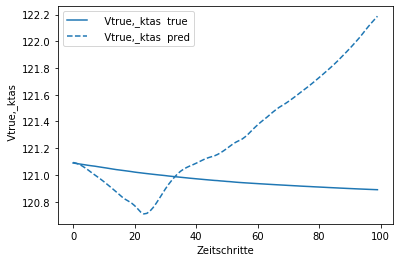

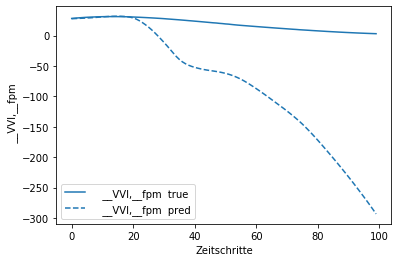

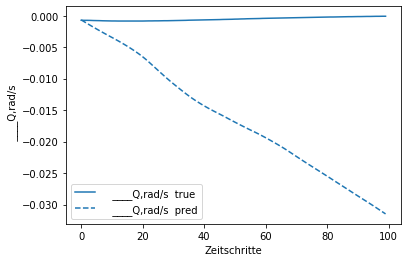

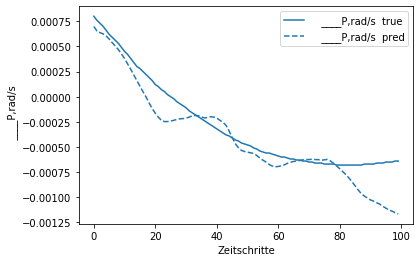

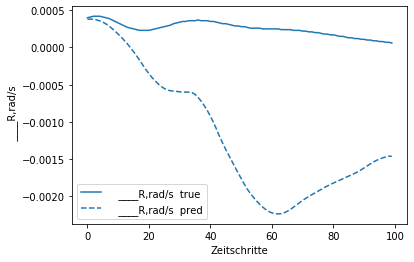

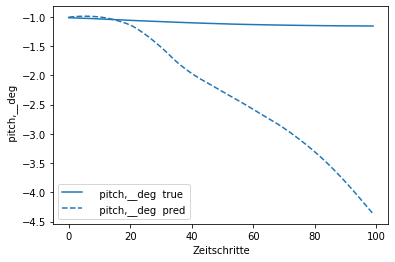

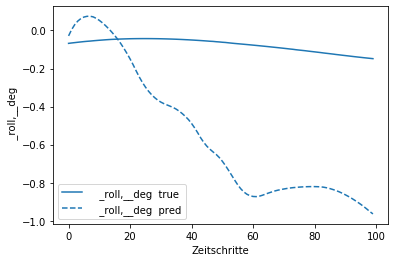

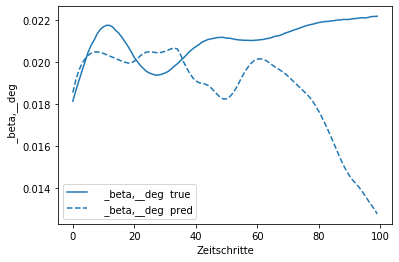

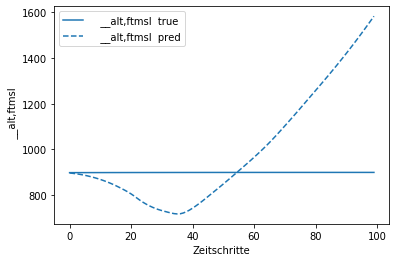

In [0]:
print_pred_and_actual(df_pred, df_real)
